In [1]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [2]:
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# Collect each day’s feature-engineered frame
frames = []
print('generating main features...')
for day, day_df in df_sign.groupby(df_sign.index.normalize()):
    # day_df has only that session’s bars
    feats_main = feats.features_creation(df = day_df, 
                                         ma_window = 20) # sma window for ATR and Volume
    frames.append(feats_main)

# Re-assemble back into one long DF
df_feat_main = pd.concat(frames).sort_index()

print('generating engineered features...')
df_feat_eng = feats.features_engineering(
                                        df = df_feat_main,
                                        low_rsi = 30,
                                        high_rsi = 70,
                                        adx_thresh = 20,
                                        adx_window = 7
                                        )

df_feat_eng

generating main features...
generating engineered features...


,feat_main_ema,feat_main_sma,feat_main_macd_line,feat_main_macd_signal,feat_main_macd_diff,feat_main_bb_lband,feat_main_bb_hband,feat_main_bb_width_20,feat_main_rsi,feat_main_plus_di,feat_main_minus_di,feat_main_adx,feat_main_atr_14,feat_main_atr_sma,feat_main_atr_ratio,feat_main_atr_ratio_sma,feat_main_obv,feat_main_obv_sma,feat_main_vwap_dev,feat_main_r_1,feat_main_r_5,feat_main_r_15,feat_main_vol_15,feat_main_volume_spike,feat_main_stoch_k_14,feat_main_stoch_d_3,feat_main_hour,feat_main_day_of_week,feat_main_month,feat_main_open,feat_main_high,feat_main_low,feat_main_close,feat_main_volume,bid,ask,signal,feat_eng_ma,feat_eng_macd,feat_eng_bb,feat_eng_rsi,feat_eng_adx,feat_eng_obv,feat_eng_atr_div
2004-01-02 13:20:00,0.764135,0.764218,-0.000055,-0.000039,-0.000016,0.764037,0.764359,0.000422,0.000000,0.000000,100.000000,100.000000,0.000011,0.000005,0.000014,0.000006,-1066843.75,-3.064250e+05,-0.000280,-0.000022,-0.000110,-0.000307,0.000010,1.927594,0.000000,0.000000,13,4,1,0.764051,0.764051,0.764051,0.764051,121712.50,0.763480,0.764623,0.096829,-0.000,-0.000,0.000,30.000,-0.000,-7.604188e+05,0.1
2004-01-02 13:21:00,0.764119,0.764208,-0.000059,-0.000043,-0.000016,0.764015,0.764356,0.000447,0.000000,0.000000,100.000000,100.000000,0.000011,0.000005,0.000015,0.000007,-1195250.00,-3.675875e+05,-0.000297,-0.000022,-0.000110,-0.000329,0.000010,1.883825,0.000000,0.000000,13,4,1,0.764035,0.764035,0.764035,0.764035,128406.25,0.763463,0.764606,0.102961,-0.000,-0.000,0.000,30.000,-0.000,-8.276625e+05,0.1
2004-01-02 13:22:00,0.764104,0.764198,-0.000062,-0.000047,-0.000016,0.763993,0.764351,0.000468,0.000000,0.000000,100.000000,100.000000,0.000012,0.000006,0.000015,0.000008,-1330350.00,-4.355050e+05,-0.000314,-0.000022,-0.000110,-0.000329,0.000009,1.837658,0.000000,0.000000,13,4,1,0.764018,0.764018,0.764018,0.764018,135100.00,0.763446,0.764589,0.109480,-0.000,-0.000,0.000,30.000,-0.000,-8.948450e+05,0.1
2004-01-02 13:23:00,0.764088,0.764187,-0.000066,-0.000050,-0.000016,0.763972,0.764343,0.000486,0.000000,0.000000,100.000000,100.000000,0.000012,0.000006,0.000016,0.000008,-1472143.75,-5.105122e+05,-0.000330,-0.000022,-0.000110,-0.000329,0.000008,1.790163,0.000000,0.000000,13,4,1,0.764001,0.764001,0.764001,0.764001,141793.75,0.763430,0.764573,0.116411,-0.000,-0.000,0.000,30.000,-0.000,-9.616316e+05,0.1
2004-01-02 13:24:00,0.764072,0.764176,-0.000069,-0.000054,-0.000015,0.763952,0.764333,0.000498,0.000000,0.000000,100.000000,100.000000,0.000012,0.000007,0.000016,0.000009,-1620631.25,-5.929438e+05,-0.000346,-0.000022,-0.000110,-0.000329,0.000007,1.742166,0.000000,0.000000,13,4,1,0.763984,0.763984,0.763984,0.763984,148487.50,0.763413,0.764556,0.123782,-0.000,-0.000,0.000,30.000,-0.000,-1.027688e+06,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.464247,196.252523,0.175662,0.134526,0.041136,195.926584,196.725006,0.004067,67.216594,36.312473,7.485222,30.194416,0.250991,0.185279,0.001275,0.000944,3774929.00,2.674136e+06,0.002191,0.000635,0.002846,0.003639,0.000724,1.952858,62.051653,56.011167,20,2,6,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.185890,0.212,0.041,-0.090,-37.217,10.194,1.100793e+06,3.3
2025-06-18 20:57:00,196.496671,196.279250,0.179462,0.143513,0.035949,195.924930,196.772160,0.004315,61.668579,34.720671,6.704415,32.868467,0.260206,0.189361,0.001323,0.000964,3314299.00,2.716659e+06,0.001453,-0.000712,0.001450,0.003081,0.000746,2.143635,64.412431,61.090338,20,2,6,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.056838,0.217,0.036,0.097,-31.669,12.868,5.976403e+05,3.6
2025-06-18 20:58:00,196.523337,196.306558,0.179996,0.150810,0.029186,195.925348,196.812742,0.004519,61.473426,33.627161,6.493263,35.351515,0.249477,0.193049,0.001269,0.000983,2789054.00,2.726865e+06,0.001403,-0.000025,0.000559,0.002291,0.000747,2.234218,

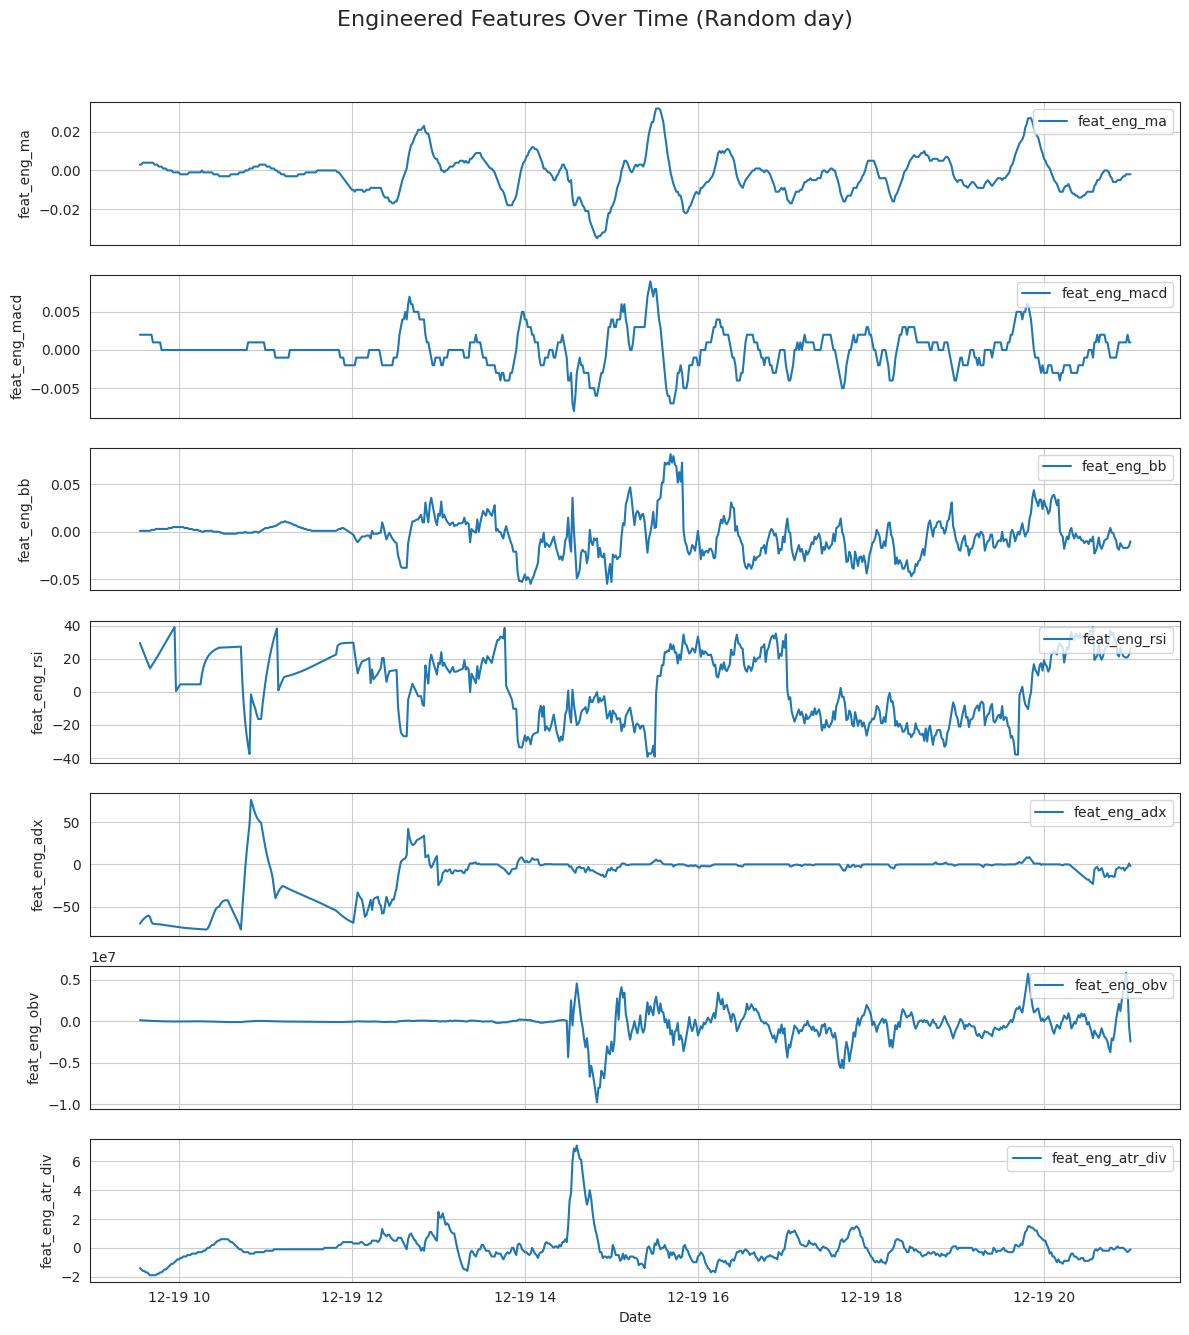

In [3]:
# Engineered features visual check

# 2. Automatically pick out all engineered-feature columns
eng_features = [col for col in df_feat_eng.columns if col.startswith('feat_eng_')]

# 3. Select a random trading day from the data
all_days    = df_feat_eng.index.normalize().unique()
random_day  = np.random.choice(all_days)

# 4. Subset the engineered features for that single day
df_random_day = df_feat_eng.loc[
    df_feat_eng.index.normalize() == random_day,
    eng_features
]

# Create vertical subplots
fig, axes = plt.subplots(len(eng_features), 1, figsize=(12, 2 * len(eng_features)), sharex=True)
fig.suptitle('Engineered Features Over Time (Random day)', fontsize=16)

for ax, feat in zip(axes, eng_features):
    ax.plot(df_random_day.index, df_random_day[feat], label=feat)
    ax.set_ylabel(feat)
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


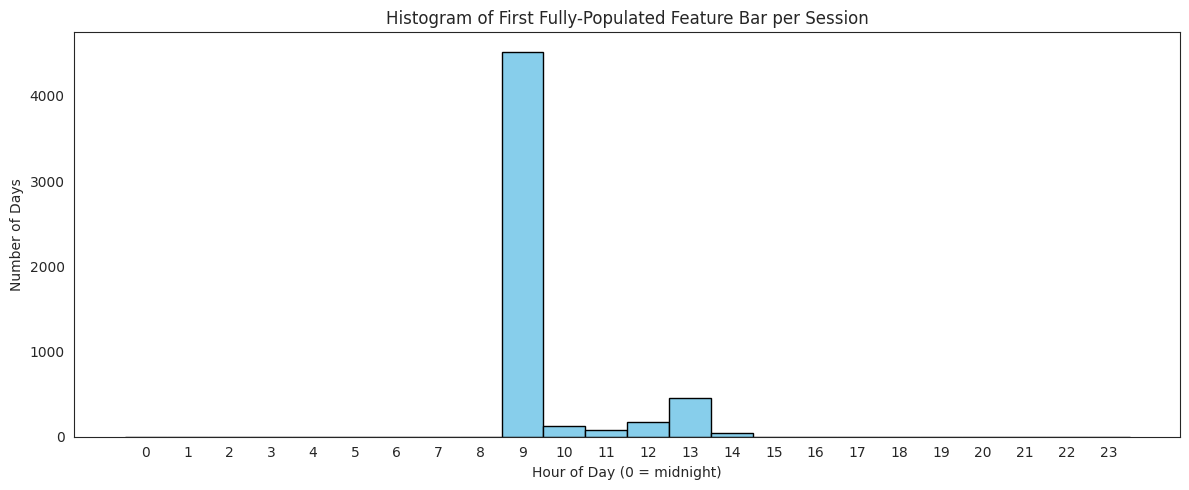

In [4]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature (every column whose name starts with "feat_") has a non-null
#   value.  Plotting the histogram of those hours tells you how long the indicators take to “warm up” each morning before your model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat_eng.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c.startswith("feat_")]

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [5]:
# feed the trimmed DataFrame into the existing call
df_feat_all = feats.scale_with_splits(
    df           = df_feat_eng,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

In [6]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
df_feat_all

saving df …


,feat_main_bb_lband,feat_main_bb_hband,feat_main_atr_14,feat_main_atr_sma,feat_main_obv,feat_main_obv_sma,feat_main_open,feat_main_high,feat_main_low,feat_main_close,feat_main_volume,feat_main_r_1,feat_main_r_5,feat_main_r_15,feat_main_vol_15,feat_main_bb_width_20,feat_main_rsi,feat_main_atr_ratio,feat_main_atr_ratio_sma,feat_main_vwap_dev,feat_main_volume_spike,feat_main_stoch_k_14,feat_main_stoch_d_3,feat_eng_ma,feat_eng_macd,feat_eng_bb,feat_eng_rsi,feat_eng_adx,feat_eng_obv,feat_eng_atr_div,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029165,-0.067744,-0.112602,-0.997659,-0.838876,-2.494214,-0.989424,-0.997100,-0.073651,0.764638,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.184772,0.001872,0.510,-0.976,0.416,0.763480,0.764623,0.096829
2004-01-02 13:21:00,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029165,-0.067746,-0.120543,-0.998730,-0.832336,-2.494214,-0.988729,-0.996170,-0.076976,0.723780,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.199896,0.001872,0.510,-0.976,0.416,0.763463,0.764606,0.102961
2004-01-02 13:22:00,-0.989613,-1.258113,0.962963,1.017212,-1.025403,-1.052332,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029166,-0.067747,-0.120546,-1.000130,-0.826683,-2.494214,-0.988084,-0.995208,-0.080213,0.680682,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.215007,0.001872,0.510,-0.976,0.416,0.763446,0.764589,0.109480
2004-01-02 13:23:00,-0.980146,-1.295403,0.951510,1.021361,-1.033031,-1.068713,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029167,-0.067748,-0.120548,-1.001950,-0.822092,-2.494214,-0.987484,-0.994215,-0.083364,0.636345,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.230028,0.001872,0.510,-0.976,0.416,0.763430,0.764573,0.116411
2004-01-02 13:24:00,-0.959905,-1.396263,0.928571,1.029833,-1.048349,-1.101550,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029167,-0.067750,-0.120551,-1.004371,-0.818764,-2.494214,-0.986928,-0.993195,-0.086429,0.591539,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.244885,0.001872,0.510,-0.976,0.416,0.763413,0.764556,0.123782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,-0.273987,0.171313,1.490552,0.763585,0.810448,0.355966,0.514056,0.712871,0.507812,0.711270,5.457497,0.835764,1.741652,1.317454,0.348646,0.119859,0.817330,0.590045,0.188423,0.405541,0.788222,0.354270,0.171950,12.076104,10.569976,-2.703249,-1.809641,0.353707,0.233838,1.374807,-0.938,0.040,0.081,196.667400,196.962600,0.185890
2025-06-18 20:57:00,-0.277244,0.237613,1.595167,0.802457,0.615883,0.371696,0.714286,0.834646,0.390625,0.485397,6.617038,-0.936790,0.887168,1.115028,0.391490,0.185120,0.543997,0.649863,0.214541,0.262395,0.966313,0.426928,0.331656,12.360953,9.281142,2.974783,-1.535979,0.453742,0.120673,1.503520,-0.938,0.040,0.081,196.527500,196.822500,0.056838
2025-06-18 20:58:00,-0.275415,0.295487,1.471839,0.842586,0.391635,0.375126,0.498008,0.520710,0.501626,0.476825,7.618132,-0.033787,0.341858,0.828680,0.392127,0.238802,0.534383,0.581581,0.238137,0.252764,1.050873,0.381698,0.395967,12.360953,7.476773,4.371518,-1.526312,0.546669,0.000243,1.203190,-0.938,0.040,0.081,196.522500,196.817500,0.000469
2025-06-18 20:59:00,-0.278458,0.295307,1.671470,0.895459,-0.465725,0.333652,0.504000,0.537549,-0.110089,-0.205079,31.539808,-2.880849,-0.842461,-0.093777,0.692828,0.242909,-0.152067,0.703827,0.269879,-0.172745,4.759109,-0.182913,0.213033,9.227624,-1.287303,17.427955,-0.839051,0.240466,-0.444516,1.503520,-0.938,0.040,0.081,196.092800,196.387200,0.000586


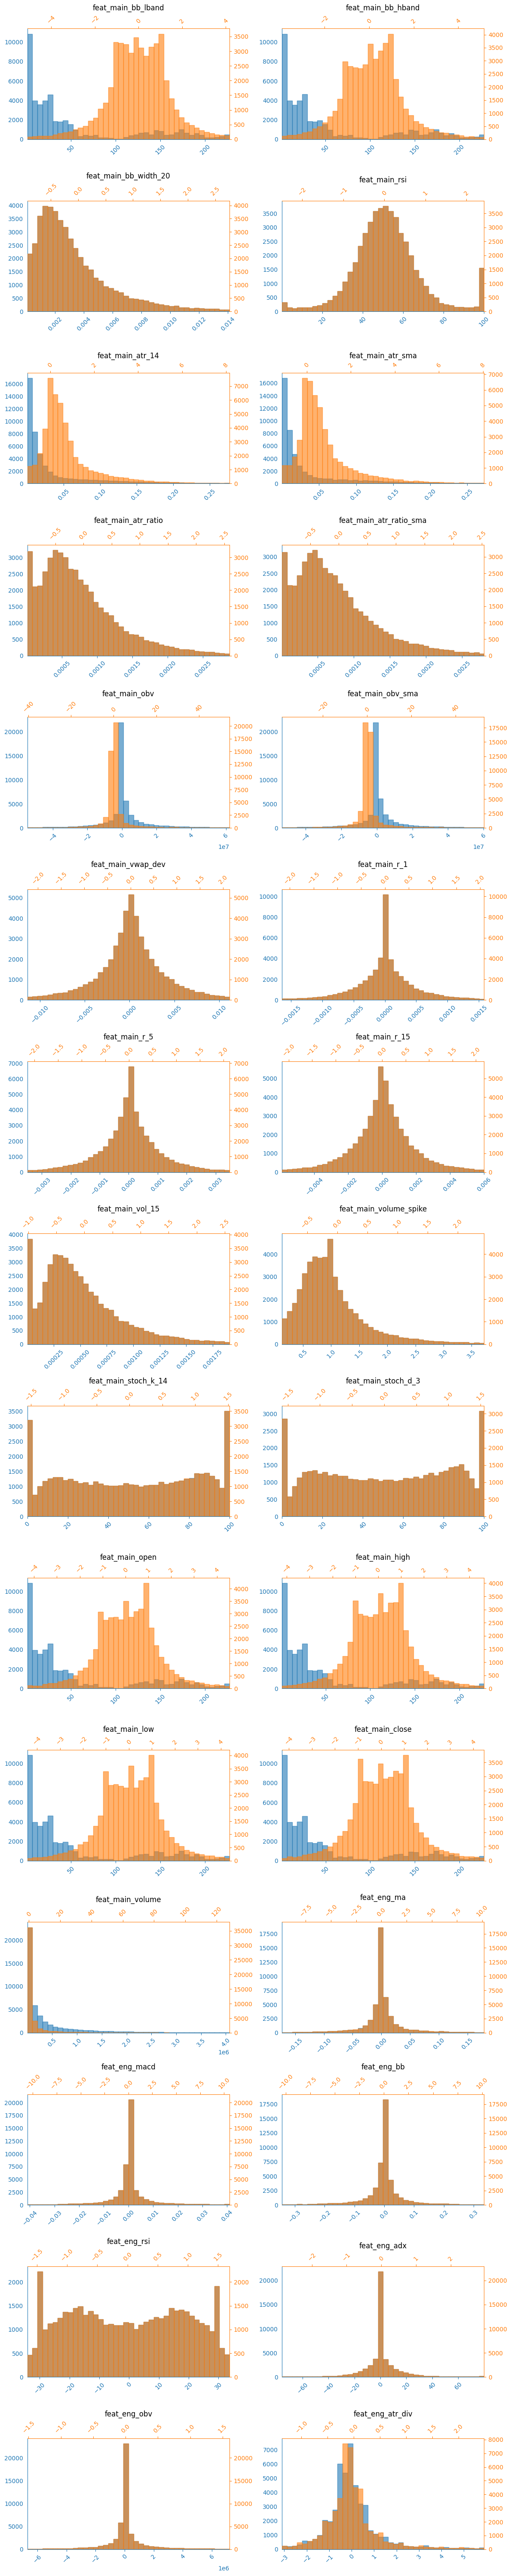

In [8]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)
df_feat_scal
importlib.reload(plots)
plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)